--- Bloco 1: Carregando e Detectando os Tiros ---
'su-agc-fk2.txt' foi identificado como Tiro Direto (A->B).
'su-bruto.txt' foi identificado como Tiro Reverso (B->A).
Distância entre tiros (AB): 13000.0 m
Tempo Recíproco (t_AB) estimado: 0.0427 s


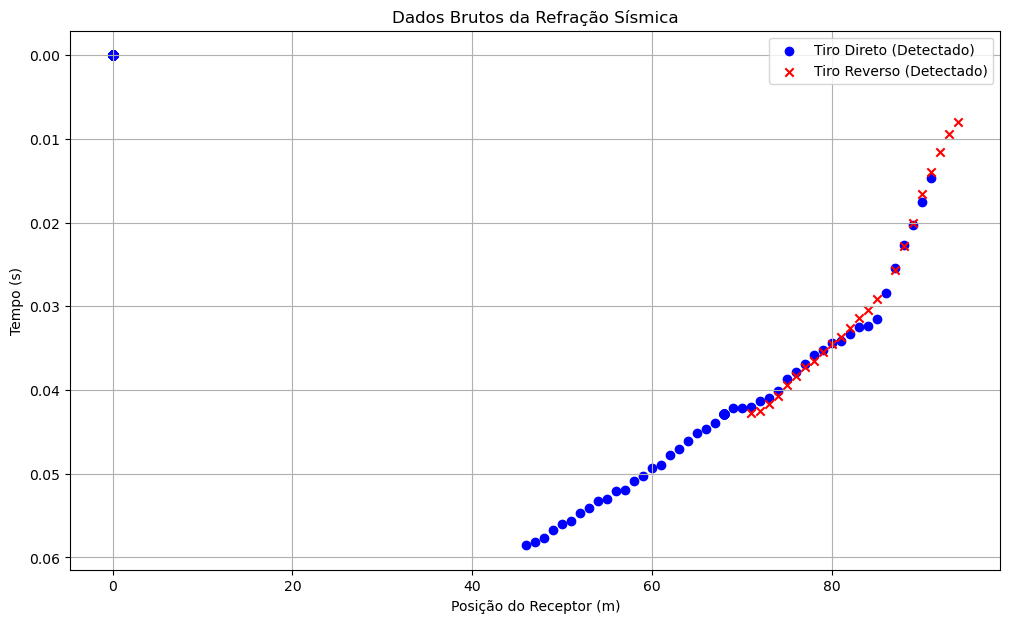


--- Bloco 2: Análise pelo Método de Interseção ---

Velocidade V1 (Tiro Direto): -26000000000.00 m/s
Velocidade V1 (Tiro Reverso): 557.57 m/s
==> Velocidade V1 Média utilizada: -12999999721.22 m/s
Velocidade Aparente Downdip (Vd): -1681.81 m/s
Velocidade Aparente Updip (Vu): 1033.52 m/s

Resultados (Interseção):
  - Ângulo Crítico Médio (ic): nan graus
  - Ângulo de Mergulho Médio (γ): nan graus
  - Velocidade Real da Camada 2 (V2) estimada: nan m/s


C:\Users\usuario\AppData\Local\Temp\ipykernel_8412\1331642820.py:104: RankWarning: Polyfit may be poorly conditioned
  incl_v1_fwd, inter_v1_fwd = np.polyfit(offset_direta_ax, t_direta_ax, 1)
C:\Users\usuario\AppData\Local\Temp\ipykernel_8412\1331642820.py:118: RuntimeWarning: invalid value encountered in arcsin
  ic_rad_medio = 0.5 * (np.arcsin(v1/vd) + np.arcsin(v1/vu))
C:\Users\usuario\AppData\Local\Temp\ipykernel_8412\1331642820.py:119: RuntimeWarning: invalid value encountered in arcsin
  gama_rad_medio = 0.5 * (np.arcsin(v1/vd) - np.arcsin(v1/vu))


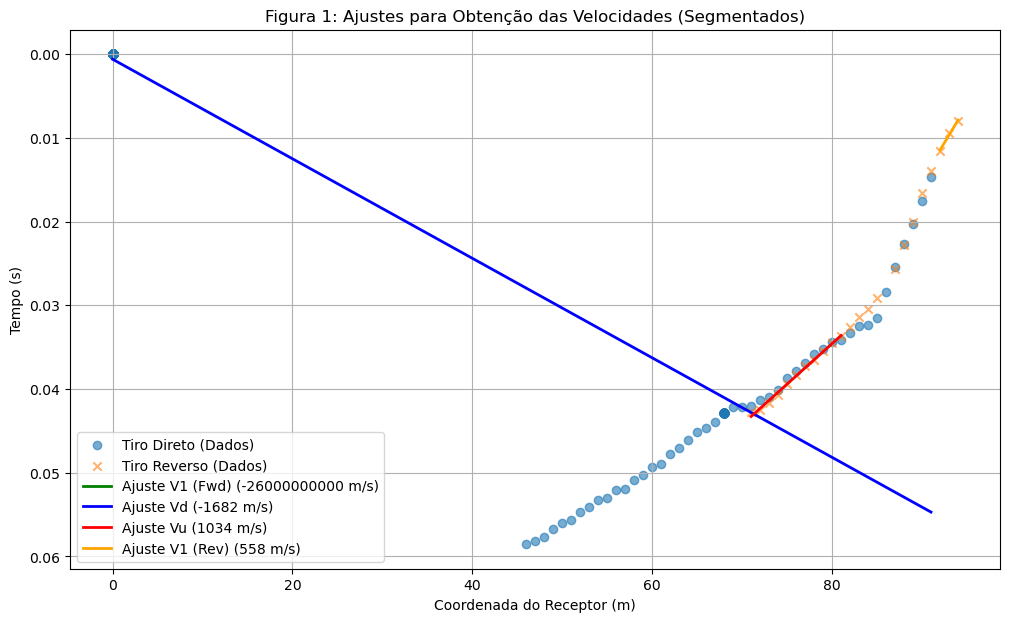


--- Bloco 3 e 4: Análise pelo Método Recíproco e Plot Final ---

Velocidade Real da Camada 2 (V2) calculada pelo M. Recíproco: 3165.73 m/s
Ângulo Crítico Real (ic) com base em V2_real: nan graus

Cálculo de profundidade finalizado. Gerando o mapa da interface...


C:\Users\usuario\AppData\Local\Temp\ipykernel_8412\1331642820.py:149: RuntimeWarning: invalid value encountered in arcsin
  ic_real_rad = np.arcsin(v1 / v2_real)


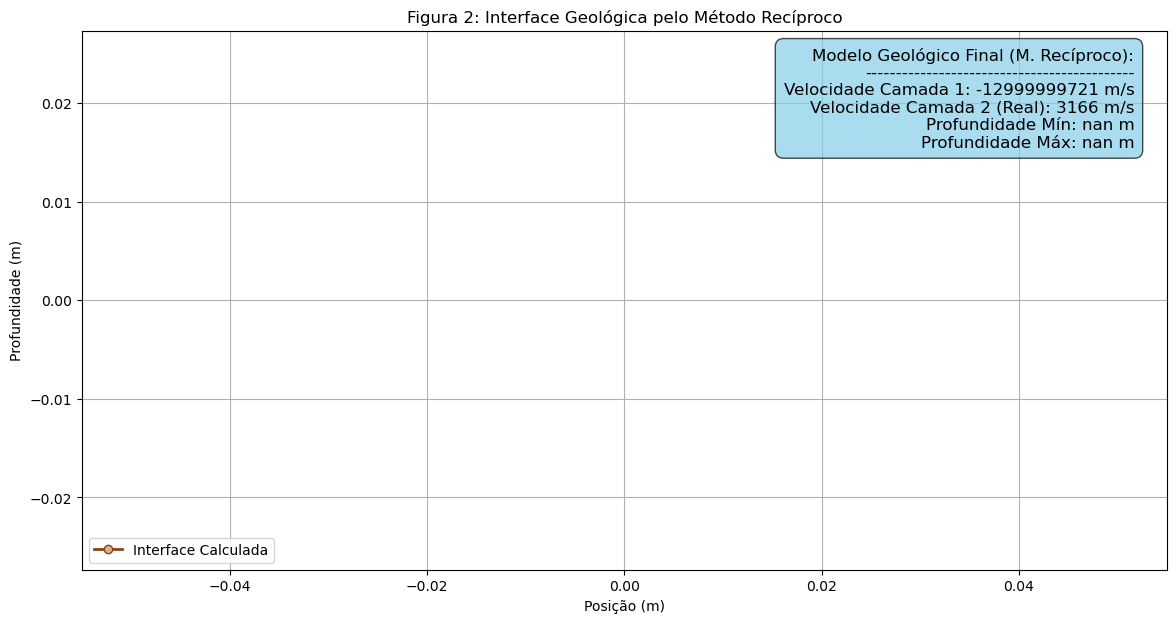


--- Modelo Geológico Final (Método Recíproco) ---
  - Velocidade da Camada 1: -12999999721 m/s
  - Velocidade da Camada 2 (Real): 3166 m/s
  - Profundidade da Interface varia de nan m a nan m


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Insira os nomes dos DOIS arquivos do par que você quer analisar.
# O código irá descobrir qual é o direto e qual é o reverso.
arquivo_1 = 'su-bruto.txt'
arquivo_2 = 'su-agc-fk2.txt'

# 2. Insira as posições de tiro correspondentes a cada arquivo (em metros).
posicao_tiro_arquivo_1 = 0.0
posicao_tiro_arquivo_2 = 13000.0

# 3. Ajuste os índices para o ajuste das retas (depois de ver o 1º gráfico)
# --- Para o Tiro Direto (A -> B) ---
n_pontos_direta_fwd = 4
indice_refratada_fwd = 4
# --- Para o Tiro Reverso (B -> A) ---
n_pontos_direta_rev = 3
indice_refratada_rev = 11
# ==============================================================================


# --- BLOCO 1: CARREGAMENTO E DETECÇÃO AUTOMÁTICA ---
print("--- Bloco 1: Carregando e Detectando os Tiros ---")
try:
    # Carrega os dados brutos (formato: tempo, posição)
    t1_bruto, pos1_bruto = np.loadtxt(arquivo_1, unpack=True)
    t2_bruto, pos2_bruto = np.loadtxt(arquivo_2, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar os arquivos: {e}")
    raise

# Ordena os dados pela posição do geofone
indices1_sorted = np.argsort(pos1_bruto)
pos1, t1 = pos1_bruto[indices1_sorted], t1_bruto[indices1_sorted]
indices2_sorted = np.argsort(pos2_bruto)
pos2, t2 = pos2_bruto[indices2_sorted], t2_bruto[indices2_sorted]

# Calcula a inclinação geral (coeficiente angular) de cada conjunto de dados
slope1, _ = np.polyfit(pos1, t1, 1)
slope2, _ = np.polyfit(pos2, t2, 1)

# Lógica de decisão para atribuir os dados às variáveis corretas
if slope1 > 0 and slope2 < 0:
    print(f"'{arquivo_1}' foi identificado como Tiro Direto (A->B).")
    print(f"'{arquivo_2}' foi identificado como Tiro Reverso (B->A).")
    pos_ax, t_ax = pos1, t1
    pos_bx, t_bx = pos2, t2
    posicao_tiro_direto = posicao_tiro_arquivo_1
    posicao_tiro_reverso = posicao_tiro_arquivo_2
elif slope2 > 0 and slope1 < 0:
    print(f"'{arquivo_2}' foi identificado como Tiro Direto (A->B).")
    print(f"'{arquivo_1}' foi identificado como Tiro Reverso (B->A).")
    pos_ax, t_ax = pos2, t2
    pos_bx, t_bx = pos1, t1
    posicao_tiro_direto = posicao_tiro_arquivo_2
    posicao_tiro_reverso = posicao_tiro_arquivo_1
else:
    print("AVISO: Não foi possível identificar um par de tiro direto/reverso.")
    print("Verifique se os arquivos correspondem a um tiro com tempo crescente e outro com tempo decrescente.")
    raise ValueError("Os dados não formam um par de perfil reverso válido.")

distancia_total_AB = abs(posicao_tiro_reverso - posicao_tiro_direto)
tempo_reciproco_AB = np.interp(distancia_total_AB, pos_ax, t_ax) if posicao_tiro_direto == 0 else np.interp(0, pos_bx, t_bx)
print(f"Distância entre tiros (AB): {distancia_total_AB:.1f} m")
print(f"Tempo Recíproco (t_AB) estimado: {tempo_reciproco_AB:.4f} s")

plt.figure(figsize=(12, 7))
plt.scatter(pos_ax, t_ax, label='Tiro Direto (Detectado)', color='blue', marker='o')
plt.scatter(pos_bx, t_bx, label='Tiro Reverso (Detectado)', color='red', marker='x')
plt.xlabel('Posição do Receptor (m)')
plt.ylabel('Tempo (s)')
plt.title('Dados Brutos da Refração Sísmica')
plt.legend()
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()


# --- BLOCO 2: ANÁLISE PELO MÉTODO DE INTERSEÇÃO ---
print("\n--- Bloco 2: Análise pelo Método de Interseção ---")

pos_direta_ax = pos_ax[:n_pontos_direta_fwd]
t_direta_ax = t_ax[:n_pontos_direta_fwd]
pos_refratada_ax = pos_ax[indice_refratada_fwd:]
t_refratada_ax = t_ax[indice_refratada_fwd:]
pos_direta_bx = pos_bx[-n_pontos_direta_rev:]
t_direta_bx = t_bx[-n_pontos_direta_rev:]
pos_refratada_bx = pos_bx[:indice_refratada_rev]
t_refratada_bx = t_bx[:indice_refratada_rev]

if len(pos_direta_ax) < 2 or len(pos_refratada_ax) < 2 or len(pos_direta_bx) < 2 or len(pos_refratada_bx) < 2:
    print("\nERRO: Número de pontos insuficiente para o ajuste das retas. Ajuste os índices no Painel de Controle.")
else:
    offset_direta_ax = np.abs(pos_direta_ax - posicao_tiro_direto)
    offset_refratada_ax = np.abs(pos_refratada_ax - posicao_tiro_direto)
    offset_direta_bx = np.abs(pos_direta_bx - posicao_tiro_reverso)
    offset_refratada_bx = np.abs(pos_refratada_bx - posicao_tiro_reverso)

    incl_v1_fwd, inter_v1_fwd = np.polyfit(offset_direta_ax, t_direta_ax, 1)
    v1_fwd = 1 / incl_v1_fwd
    print(f"\nVelocidade V1 (Tiro Direto): {v1_fwd:.2f} m/s")
    incl_v1_rev, inter_v1_rev = np.polyfit(offset_direta_bx, t_direta_bx, 1)
    v1_rev = abs(1 / incl_v1_rev)
    print(f"Velocidade V1 (Tiro Reverso): {v1_rev:.2f} m/s")
    v1 = (v1_fwd + v1_rev) / 2
    print(f"==> Velocidade V1 Média utilizada: {v1:.2f} m/s")
    incl_vd, inter_vd = np.polyfit(offset_refratada_ax, t_refratada_ax, 1)
    vd = 1 / incl_vd
    print(f"Velocidade Aparente Downdip (Vd): {vd:.2f} m/s")
    incl_vu, inter_vu = np.polyfit(offset_refratada_bx, t_refratada_bx, 1)
    vu = abs(1 / incl_vu)
    print(f"Velocidade Aparente Updip (Vu): {vu:.2f} m/s")
    ic_rad_medio = 0.5 * (np.arcsin(v1/vd) + np.arcsin(v1/vu))
    gama_rad_medio = 0.5 * (np.arcsin(v1/vd) - np.arcsin(v1/vu))
    v2_intersecao = v1 / np.sin(ic_rad_medio)
    print(f"\nResultados (Interseção):")
    print(f"  - Ângulo Crítico Médio (ic): {np.degrees(ic_rad_medio):.2f} graus")
    print(f"  - Ângulo de Mergulho Médio (γ): {np.degrees(gama_rad_medio):.2f} graus")
    print(f"  - Velocidade Real da Camada 2 (V2) estimada: {v2_intersecao:.2f} m/s")
    plt.figure(figsize=(12, 7))
    plt.scatter(pos_ax, t_ax, label='Tiro Direto (Dados)', alpha=0.6)
    plt.scatter(pos_bx, t_bx, label='Tiro Reverso (Dados)', alpha=0.6, marker='x')
    plt.plot(pos_direta_ax, incl_v1_fwd * offset_direta_ax + inter_v1_fwd, '-g', lw=2, label=f'Ajuste V1 (Fwd) ({v1_fwd:.0f} m/s)')
    plt.plot(pos_refratada_ax, incl_vd * offset_refratada_ax + inter_vd, '-b', lw=2, label=f'Ajuste Vd ({vd:.0f} m/s)')
    plt.plot(pos_refratada_bx, incl_vu * offset_refratada_bx + inter_vu, '-r', lw=2, label=f'Ajuste Vu ({vu:.0f} m/s)')
    plt.plot(pos_direta_bx, incl_v1_rev * offset_direta_bx + inter_v1_rev, '-', color='orange', lw=2, label=f'Ajuste V1 (Rev) ({v1_rev:.0f} m/s)')
    plt.xlabel('Coordenada do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title('Figura 1: Ajustes para Obtenção das Velocidades (Segmentados)')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.savefig('ajustes_velocidades.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- BLOCO 3 E 4: ANÁLISE PELO MÉTODO RECÍPROCO E PLOT FINAL ---
    print("\n--- Bloco 3 e 4: Análise pelo Método Recíproco e Plot Final ---")
    t_bx_interp = np.interp(pos_ax, pos_bx, t_bx)
    t_v_menos = 0.5 * (t_ax - t_bx_interp + tempo_reciproco_AB)
    incl_v2_real, inter_aA = np.polyfit(pos_ax, t_v_menos, 1)
    v2_real = 1 / incl_v2_real
    print(f"\nVelocidade Real da Camada 2 (V2) calculada pelo M. Recíproco: {v2_real:.2f} m/s")
    delay_time_ax = 0.5 * (t_ax + t_bx_interp - tempo_reciproco_AB)
    ic_real_rad = np.arcsin(v1 / v2_real)
    print(f"Ângulo Crítico Real (ic) com base em V2_real: {np.degrees(ic_real_rad):.2f} graus")
    hx_perp = (delay_time_ax * v1) / np.cos(ic_real_rad)
    Zx_vertical = hx_perp / np.cos(gama_rad_medio)
    print("\nCálculo de profundidade finalizado. Gerando o mapa da interface...")
    plt.figure(figsize=(14, 7))
    plt.plot(pos_ax, -Zx_vertical, 'o-', label='Interface Calculada', color='saddlebrown', mfc='tan', lw=2)
    plt.xlabel('Posição (m)')
    plt.ylabel('Profundidade (m)')
    plt.title('Figura 2: Interface Geológica pelo Método Recíproco')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.axis('equal')
    texto_modelo_final = (
        f"Modelo Geológico Final (M. Recíproco):\n"
        f"--------------------------------------------\n"
        f"Velocidade Camada 1: {v1:.0f} m/s\n"
        f"Velocidade Camada 2 (Real): {v2_real:.0f} m/s\n"
        f"Profundidade Mín: {np.min(Zx_vertical):.1f} m\n"
        f"Profundidade Máx: {np.max(Zx_vertical):.1f} m"
    )
    plt.text(0.97, 0.97, texto_modelo_final,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='skyblue', alpha=0.7))
    plt.savefig('interface_reciproco.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n--- Modelo Geológico Final (Método Recíproco) ---")
    print(f"  - Velocidade da Camada 1: {v1:.0f} m/s")
    print(f"  - Velocidade da Camada 2 (Real): {v2_real:.0f} m/s")
    print(f"  - Profundidade da Interface varia de {np.min(Zx_vertical):.1f} m a {np.max(Zx_vertical):.1f} m")

--- Analisando o arquivo: su-bruto.txt ---
Arquivo 'su-bruto.txt' carregado com 23 pontos.

Velocidade da Onda Direta (V1): 1489.20 m/s
Velocidade da Onda Refratada (Vap): 594.14 m/s
Gráfico salvo como: analise_su-bruto.png


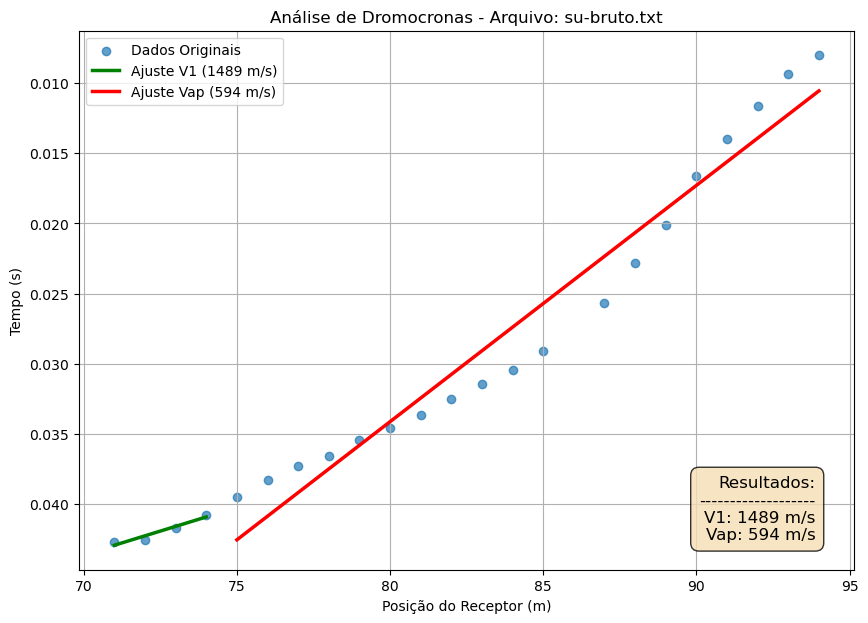

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'su-bruto.txt'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Olhe o gráfico de pontos e ajuste os índices para o ajuste das retas
n_pontos_direta = 4          # Número de pontos na reta da onda direta (contando do início)
indice_inicio_refratada = 4  # A refração começa no (N+1)º ponto (ex: 4 significa que começa no 5º ponto)

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    # Carrega os dados no formato (tempo, posição)
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    print("Verifique o nome e se o arquivo está na mesma pasta do script.")
    raise

# Ordena os dados pela posição para garantir a ordem correta
indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta ---
pos_direta = posicoes[:n_pontos_direta]
t_direta = tempos[:n_pontos_direta]

pos_refratada = posicoes[indice_inicio_refratada:]
t_refratada = tempos[indice_inicio_refratada:]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
# Verifica se há pontos suficientes para o ajuste
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))

    # Plota todos os pontos de dados do arquivo
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7)

    # Plota as retas de ajuste APENAS nos segmentos corretos
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    # Adiciona uma caixa de texto com os resultados
    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Configurações do gráfico
    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    # Salva a figura com um nome único baseado no nome do arquivo de entrada
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

--- Analisando o arquivo: suagc-fpb-fk2.txt ---
Arquivo 'suagc-fpb-fk2.txt' carregado com 118 pontos.

Velocidade da Onda Direta (V1): 734.21 m/s
Velocidade da Onda Refratada (Vap): 1536.77 m/s
Gráfico salvo como: analise_suagc-fpb-fk2.png


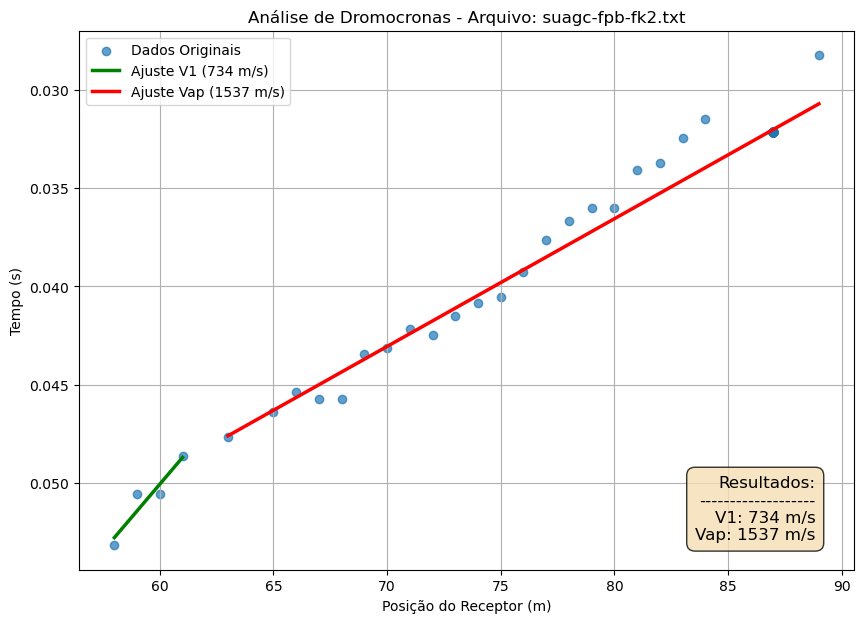

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'suagc-fpb-fk2.txt'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Olhe o gráfico de pontos e ajuste os índices para o ajuste das retas
n_pontos_direta = 4          # Número de pontos na reta da onda direta (contando do início)
indice_inicio_refratada = 4  # A refração começa no (N+1)º ponto (ex: 4 significa que começa no 5º ponto)

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    # Carrega os dados no formato (tempo, posição)
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    print("Verifique o nome e se o arquivo está na mesma pasta do script.")
    raise

# Ordena os dados pela posição para garantir a ordem correta
indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta ---
pos_direta = posicoes[:n_pontos_direta]
t_direta = tempos[:n_pontos_direta]

pos_refratada = posicoes[indice_inicio_refratada:]
t_refratada = tempos[indice_inicio_refratada:]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
# Verifica se há pontos suficientes para o ajuste
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))

    # Plota todos os pontos de dados do arquivo
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7)

    # Plota as retas de ajuste APENAS nos segmentos corretos
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    # Adiciona uma caixa de texto com os resultados
    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Configurações do gráfico
    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    # Salva a figura com um nome único baseado no nome do arquivo de entrada
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

--- Analisando o arquivo: su-agc.txt ---
Arquivo 'su-agc.txt' carregado com 24 pontos.

Velocidade da Onda Direta (V1): 3904.72 m/s
Velocidade da Onda Refratada (Vap): 793.35 m/s
Gráfico salvo como: analise_su-agc.png


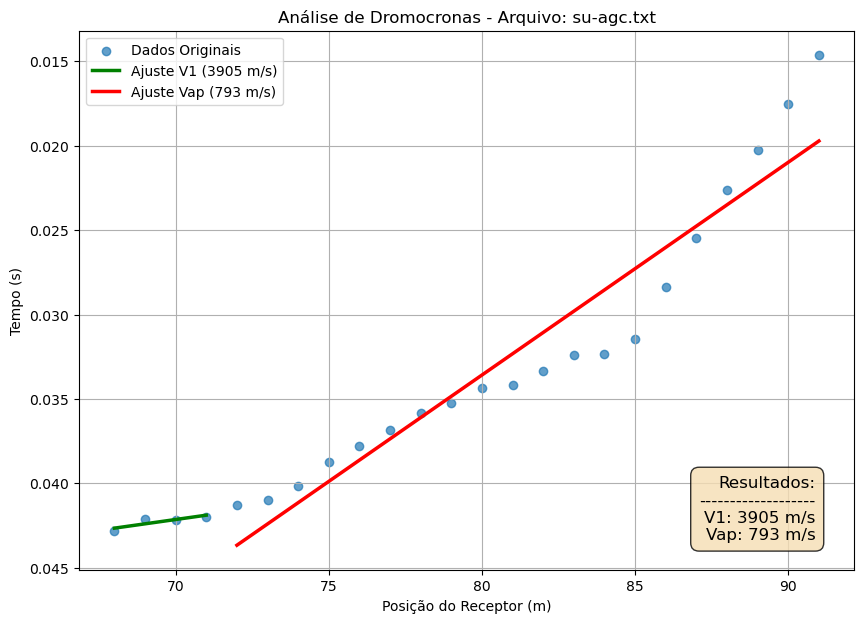

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'su-agc.txt'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Olhe o gráfico de pontos e ajuste os índices para o ajuste das retas
n_pontos_direta = 4          # Número de pontos na reta da onda direta (contando do início)
indice_inicio_refratada = 4  # A refração começa no (N+1)º ponto (ex: 4 significa que começa no 5º ponto)

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    # Carrega os dados no formato (tempo, posição)
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    print("Verifique o nome e se o arquivo está na mesma pasta do script.")
    raise

# Ordena os dados pela posição para garantir a ordem correta
indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta ---
pos_direta = posicoes[:n_pontos_direta]
t_direta = tempos[:n_pontos_direta]

pos_refratada = posicoes[indice_inicio_refratada:]
t_refratada = tempos[indice_inicio_refratada:]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
# Verifica se há pontos suficientes para o ajuste
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))

    # Plota todos os pontos de dados do arquivo
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7)

    # Plota as retas de ajuste APENAS nos segmentos corretos
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    # Adiciona uma caixa de texto com os resultados
    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Configurações do gráfico
    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    # Salva a figura com um nome único baseado no nome do arquivo de entrada
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

--- Analisando o arquivo: su-agc-fpb.txt ---
Arquivo 'su-agc-fpb.txt' carregado com 32 pontos.

Velocidade da Onda Direta (V1): 1047.81 m/s
Velocidade da Onda Refratada (Vap): 992.92 m/s
Gráfico salvo como: analise_su-agc-fpb.png


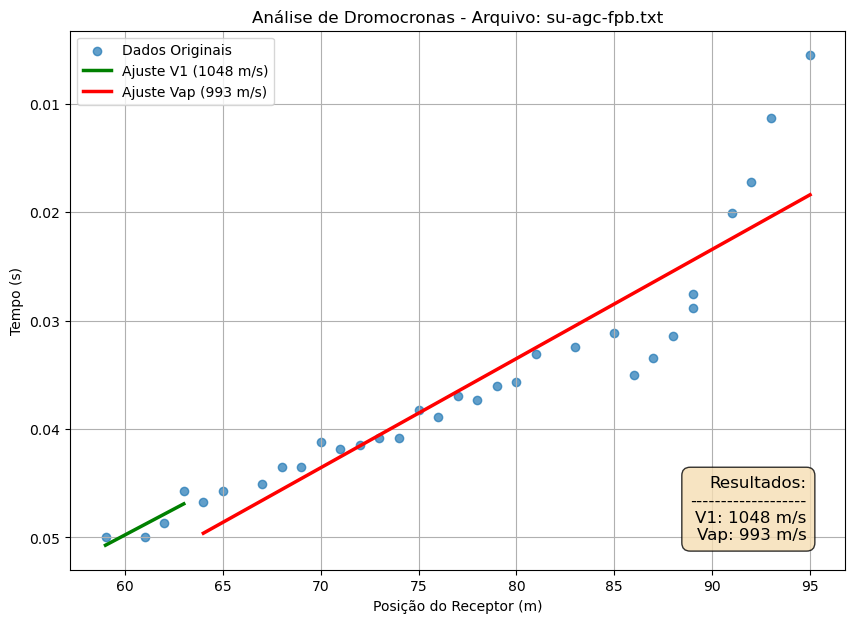

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'su-agc-fpb.txt'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Olhe o gráfico de pontos e ajuste os índices para o ajuste das retas
n_pontos_direta = 4          # Número de pontos na reta da onda direta (contando do início)
indice_inicio_refratada = 4  # A refração começa no (N+1)º ponto (ex: 4 significa que começa no 5º ponto)

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    # Carrega os dados no formato (tempo, posição)
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    print("Verifique o nome e se o arquivo está na mesma pasta do script.")
    raise

# Ordena os dados pela posição para garantir a ordem correta
indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta ---
pos_direta = posicoes[:n_pontos_direta]
t_direta = tempos[:n_pontos_direta]

pos_refratada = posicoes[indice_inicio_refratada:]
t_refratada = tempos[indice_inicio_refratada:]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
# Verifica se há pontos suficientes para o ajuste
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))

    # Plota todos os pontos de dados do arquivo
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7)

    # Plota as retas de ajuste APENAS nos segmentos corretos
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    # Adiciona uma caixa de texto com os resultados
    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Configurações do gráfico
    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    # Salva a figura com um nome único baseado no nome do arquivo de entrada
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'su-agc-fk2.txt'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Olhe o gráfico de pontos e ajuste os índices para o ajuste das retas
n_pontos_direta = 4          # Número de pontos na reta da onda direta (contando do início)
indice_inicio_refratada = 4  # A refração começa no (N+1)º ponto (ex: 4 significa que começa no 5º ponto)

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    # Carrega os dados no formato (tempo, posição)
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    print("Verifique o nome e se o arquivo está na mesma pasta do script.")
    raise

# Ordena os dados pela posição para garantir a ordem correta
indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta ---
pos_direta = posicoes[:n_pontos_direta]
t_direta = tempos[:n_pontos_direta]

pos_refratada = posicoes[indice_inicio_refratada:]
t_refratada = tempos[indice_inicio_refratada:]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
# Verifica se há pontos suficientes para o ajuste
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))

    # Plota todos os pontos de dados do arquivo
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7)

    # Plota as retas de ajuste APENAS nos segmentos corretos
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    # Adiciona uma caixa de texto com os resultados
    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Configurações do gráfico
    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    # Salva a figura com um nome único baseado no nome do arquivo de entrada
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

--- Analisando o arquivo: su-agc-fk2.txt ---
Arquivo 'su-agc-fk2.txt' carregado com 406 pontos.


D:\miniforge3\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

--- Analisando o arquivo: su-agc-corta-d.txt ---
Arquivo 'su-agc-corta-d.txt' carregado com 122 pontos.

Velocidade da Onda Direta (V1): 2302.56 m/s
Velocidade da Onda Refratada (Vap): 1148.57 m/s
Gráfico salvo como: analise_su-agc-corta-d.png


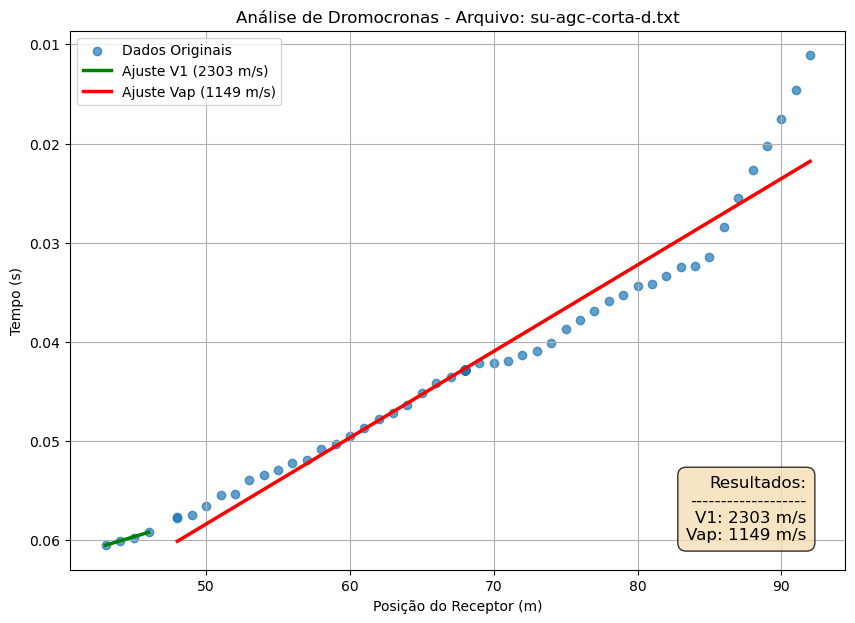

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'su-agc-corta-d.txt'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Olhe o gráfico de pontos e ajuste os índices para o ajuste das retas
n_pontos_direta = 4          # Número de pontos na reta da onda direta (contando do início)
indice_inicio_refratada = 4  # A refração começa no (N+1)º ponto (ex: 4 significa que começa no 5º ponto)

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    # Carrega os dados no formato (tempo, posição)
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    print("Verifique o nome e se o arquivo está na mesma pasta do script.")
    raise

# Ordena os dados pela posição para garantir a ordem correta
indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta ---
pos_direta = posicoes[:n_pontos_direta]
t_direta = tempos[:n_pontos_direta]

pos_refratada = posicoes[indice_inicio_refratada:]
t_refratada = tempos[indice_inicio_refratada:]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
# Verifica se há pontos suficientes para o ajuste
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))

    # Plota todos os pontos de dados do arquivo
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7)

    # Plota as retas de ajuste APENAS nos segmentos corretos
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    # Adiciona uma caixa de texto com os resultados
    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    # Configurações do gráfico
    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    # Salva a figura com um nome único baseado no nome do arquivo de entrada
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# PAINEL DE CONTROLE (Configure sua análise precisa aqui)
# ==============================================================================

# 1. Coloque o nome do arquivo .txt que você quer analisar
nome_do_arquivo = 'su-agc-corta-ddat'  # <--- MUDE O NOME DO ARQUIVO AQUI A CADA ANÁLISE

# 2. Defina os limites (início e fim) para cada reta, usando os índices dos pontos.
# Lembre-se: o 'fim' é (índice do último ponto + 1).

# --- Para a ONDA DIRETA (V1) ---
# Exemplo: Para pegar os 4 primeiros pontos (índices 0, 1, 2, 3)
inicio_direta = 121
fim_direta = 113

# --- Para a ONDA REFRATADA (Vap) ---
# Exemplo: Para pegar do 5º ponto (índice 4) até o 23º ponto (índice 22)
inicio_refratada = 112
fim_refratada = 23    # Use len(posicoes) se quiser ir até o último ponto.

# ==============================================================================


print(f"--- Analisando o arquivo: {nome_do_arquivo} ---")

# --- 1. Carregar e Preparar os Dados ---
try:
    tempos_brutos, posicoes_brutas = np.loadtxt(nome_do_arquivo, unpack=True)
except Exception as e:
    print(f"ERRO ao carregar o arquivo: {e}")
    raise

indices_sorted = np.argsort(posicoes_brutas)
posicoes = posicoes_brutas[indices_sorted]
tempos = tempos_brutos[indices_sorted]

print(f"Arquivo '{nome_do_arquivo}' carregado com {len(posicoes)} pontos.")

# --- 2. Selecionar os Pontos para Cada Reta usando os Limites ---
pos_direta = posicoes[inicio_direta:fim_direta]
t_direta = tempos[inicio_direta:fim_direta]

pos_refratada = posicoes[inicio_refratada:fim_refratada]
t_refratada = tempos[inicio_refratada:fim_refratada]

# --- 3. Calcular Coeficientes Angulares e Velocidades ---
if len(pos_direta) < 2 or len(pos_refratada) < 2:
    print("ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.")
else:
    # Ajuste da onda direta
    incl_v1, inter_v1 = np.polyfit(pos_direta, t_direta, 1)
    v1 = abs(1 / incl_v1)
    print(f"\nVelocidade da Onda Direta (V1): {v1:.2f} m/s")

    # Ajuste da onda refratada
    incl_vap, inter_vap = np.polyfit(pos_refratada, t_refratada, 1)
    vap = abs(1 / incl_vap)
    print(f"Velocidade da Onda Refratada (Vap): {vap:.2f} m/s")

    # --- 4. Gerar o Gráfico Individual ---
    plt.figure(figsize=(10, 7))
    plt.scatter(posicoes, tempos, label='Dados Originais', marker='o', alpha=0.7, c='gray')
    plt.plot(pos_direta, incl_v1 * pos_direta + inter_v1, '-g', lw=2.5, label=f'Ajuste V1 ({v1:.0f} m/s)')
    plt.plot(pos_refratada, incl_vap * pos_refratada + inter_vap, '-r', lw=2.5, label=f'Ajuste Vap ({vap:.0f} m/s)')

    texto_resultados = (
        f"Resultados:\n"
        f"-------------------\n"
        f"V1: {v1:.0f} m/s\n"
        f"Vap: {vap:.0f} m/s"
    )
    plt.text(0.95, 0.05, texto_resultados,
             transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='bottom',
             horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.8))

    plt.xlabel('Posição do Receptor (m)')
    plt.ylabel('Tempo (s)')
    plt.title(f'Análise de Dromocronas - Arquivo: {nome_do_arquivo}')
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()
    
    nome_figura = f'analise_{nome_do_arquivo.replace(".txt", "")}.png'
    plt.savefig(nome_figura, dpi=300, bbox_inches='tight')
    print(f"Gráfico salvo como: {nome_figura}")

    plt.show()

--- Analisando o arquivo: su-agc-corta-d.txt ---
Arquivo 'su-agc-corta-d.txt' carregado com 122 pontos.
ERRO: Pontos insuficientes para o ajuste. Verifique os índices no Painel de Controle.
